**Task 4:** Same as Task 3 using the single hidden layer LSTM network based decoder 

In [1]:
# **Task 4:** Same as Task 3 using the single hidden layer LSTM network based decoder 

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
from collections import Counter
from itertools import chain
from IPython.display import clear_output
import time


In [4]:
# import zipfile

# # Replace 'file_name.zip' with the name of your zip file
# zip_file_path = '/content/drive/MyDrive/Colab Notebooks/Images.zip'

# extract_to_path = '/content/'

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to_path)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.makedirs('models/Q4', exist_ok=True)

In [6]:
torch.cuda.is_available()

True

In [7]:
# dataset structure:
# ./dataset/captioning/Images/ - contains all images
# ./dataset/captioning/image_names.txt - contains all image names that will be used for training. Rest of the images will be used for testing.
# note that the order of image names in image_names.txt is random.
# ./dataset/captioning/captions.txt - contains image names and 5 captions for each image.
# example from captions.txt:
# 1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
# 1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
# 1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
# 1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
# 1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
# 1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
# 1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
# 1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .
# 1001773457_577c3a7d70.jpg#3	Two dogs of different breeds looking at each other on the road .
# 1001773457_577c3a7d70.jpg#4	Two dogs on pavement moving toward each other .

# again note that the order of image names in image_names.txt is random and not in the same order as in captions.txt.


In [8]:

class ImageCaptioningDataset(Dataset):
    def __init__(self, root_dir, captions_file, image_names_file, transform=None, split='train'):
        """
        Args:
            root_dir (string): Directory with all the images.
            captions_file (string): Path to the captions file.
            image_names_file (string): Path to the file with image names for training.
            transform (callable, optional): Optional transform to be applied on an image.
            split (string, optional): The dataset split, either 'train' or 'test'.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        self.images = []
        self.captions = []
        self.image_names = set()

        # Load image names for training or testing
        with open(image_names_file, 'r') as f:
            for line in f:
                self.image_names.add(line.strip())

        # Load captions and associate them with images
        with open(captions_file, 'r') as f:
            for line in f:
                image_name, caption = line.strip().split('\t')
                image_name = image_name.split('#')[0]
                if (split == 'train' and image_name in self.image_names) or \
                   (split == 'test' and image_name not in self.image_names):
                    self.images.append(image_name)
                    self.captions.append(caption)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]
        image_path = os.path.join(self.root_dir, 'Images', image_name)
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        caption = self.captions[idx]
        return image, caption

In [9]:
nltk.download('punkt')

class Vocabulary:
    def __init__(self, freq_threshold):
        # A counter to hold the frequency of each word
        self.freq_threshold = freq_threshold
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}

    def build_vocabulary(self, sentence_list):
        frequencies = Counter(chain(*sentence_list))
        # Only include words that appear at least freq_threshold times
        # self.itos.update({idx + 4: token for idx, (token, count) in enumerate(frequencies.items()) if count >= self.freq_threshold and len(token) > 2})
        for token, count in frequencies.items():
#             if count >= self.freq_threshold and token.isalpha() and len(token) > 1:
            if count >= self.freq_threshold:
                index = len(self.itos)
                self.itos[index] = token
                self.stoi[token] = index

    def numericalize(self, text):
        # Convert each token to its index; if it's not in the vocabulary, replace it with <UNK>
        return [self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in text]

    def tokenize(self, text):
        return nltk.tokenize.word_tokenize(text.lower())

    def pad(self, numericalized_caption, max_length):
        # Pad the numericalized caption to the max_length with the <PAD> token index
        return numericalized_caption + ([self.stoi["<PAD>"]] * (max_length - len(numericalized_caption)))


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
def calculate_bleu_score(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25)):
    """
    Calculate the BLEU score between references and hypotheses.

    Parameters:
    - references (list of list of str): List of reference sentences.
    - hypotheses (list of list of str): List of hypothesis sentences.
    - weights (tuple of float, optional): Weights for n-grams in BLEU calculation.

    Returns:
    - bleu_score (float): The BLEU score.
    """
    smoothing_function = SmoothingFunction().method1
    total_score = 0.0
    num_sentences = len(references)

    for ref, hyp in zip(references, hypotheses):
        score = sentence_bleu([ref], hyp, weights=weights, smoothing_function=smoothing_function)
        total_score += score

    return total_score / num_sentences

def calculate_bleu_scores(references, hypotheses):
    """
    Calculate BLEU scores for 1-gram to 4-gram between references and hypotheses.

    Parameters:
    - references (list of list of str): List of reference sentences.
    - hypotheses (list of list of str): List of hypothesis sentences.

    Returns:
    - bleu_scores (list of float): List of BLEU scores for 1-gram to 4-gram.
    """
    bleu_scores = []
    for i in range(1, 5):
        weights = tuple(1.0 if j == i else 0.0 for j in range(1, 5))
        bleu_score = calculate_bleu_score(references, hypotheses, weights=weights)
        bleu_scores.append(bleu_score)

    return bleu_scores

In [11]:
# Define the NetVLAD layer
class NetVLAD(nn.Module):
    def __init__(self, num_clusters=2, dim=512, alpha=100.0, normalize_input=True):
        """
        Initialize the NetVLAD layer.

        Parameters:
        - num_clusters (int): The number of clusters to use.
        - dim (int): The dimension of the descriptors.
        - alpha (float): The parameter for controlling the soft assignment.
        - normalize_input (bool): Whether to normalize the input features.
        """
        super(NetVLAD, self).__init__()
        self.num_clusters = num_clusters
        self.dim = dim
        self.alpha = alpha
        self.normalize_input = normalize_input

        # Convolutional layer to compute soft assignment to clusters
        self.conv = nn.Conv2d(dim, num_clusters, kernel_size=(1, 1), bias=True)

        # The centroids for each cluster
        self.centroids = nn.Parameter(torch.rand(num_clusters, dim))

        # Initialize parameters
        self._init_params()

    def _init_params(self):
        """
        Initialize the parameters of the convolutional layer and centroids.
        """
        # Initialize the weights of the convolutional layer
        self.conv.weight = nn.Parameter(
            (2.0 * self.alpha * self.centroids).unsqueeze(-1).unsqueeze(-1)
        )
        # Initialize the biases of the convolutional layer
        self.conv.bias = nn.Parameter(
            - self.alpha * self.centroids.norm(dim=1)
        )

    def forward(self, x):
        """
        Forward pass of the NetVLAD layer.

        Parameters:
        - x (torch.Tensor): The input tensor with shape (N, C, H, W).

        Returns:
        - vlad (torch.Tensor): The NetVLAD descriptor for the input.
        """
        N, C = x.shape[:2]

        # Normalize the input if required
        if self.normalize_input:
            x = F.normalize(x, p=2, dim=1)

        # Compute soft assignment to clusters
        soft_assign = self.conv(x).view(N, self.num_clusters, -1)
        soft_assign = F.softmax(soft_assign, dim=1)

        # Flatten the input tensor
        x_flatten = x.view(N, C, -1)

        # Compute the residuals to each cluster centroid
        residual = x_flatten.expand(self.num_clusters, -1, -1, -1).permute(1, 0, 2, 3) - \
            self.centroids.expand(x_flatten.size(-1), -1, -1).permute(1, 2, 0).unsqueeze(0)
        residual *= soft_assign.unsqueeze(2)

        # Aggregate the residuals across all locations
        vlad = residual.sum(dim=-1)

        # Normalize the aggregated residuals
        vlad = F.normalize(vlad, p=2, dim=2)
        vlad = vlad.view(x.size(0), -1)
        vlad = F.normalize(vlad, p=2, dim=1)

        return vlad


In [12]:
base_model = models.resnet18(pretrained=True)
base_model = nn.Sequential(*list(base_model.children())[:-2])
print(base_model(torch.randn(1, 3, 224, 224)).shape) # torch.Size([1, 512, 7, 7])

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s] 


torch.Size([1, 512, 7, 7])


In [13]:
# Define the Encoder
class Encoder(nn.Module):
    def __init__(self, num_clusters=2, dim=512):  # k = 2
        super(Encoder, self).__init__()
        self.base_model = models.resnet18(pretrained=True)
        # Remove the last two layers (pooling and linear) from ResNet-18
        self.base_model = nn.Sequential(*list(self.base_model.children())[:-2])
        # Freeze the weights of the base model
        for param in self.base_model.parameters():
            param.requires_grad = False
        # Add NetVLAD layer
        self.net_vlad = NetVLAD(num_clusters=num_clusters, dim=dim)

    def forward(self, x):
        # Pass the input through the base CNN model
        x = self.base_model(x)
        # Pass the CNN features through the NetVLAD layer
        x = self.net_vlad(x)
        return x


In [14]:
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, vocab_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions, lengths):
        embeddings = self.embedding(captions)
        # Concatenate the features from the encoder with the embeddings
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True)
        lstm_out, (hidden, cell) = self.lstm(packed)
        outputs = self.out(lstm_out[0])
        return outputs

    def initHidden(self, batch_size, device):
        return (torch.zeros(1, batch_size, self.hidden_size).to(device),
                torch.zeros(1, batch_size, self.hidden_size).to(device))


In [15]:
# from torchtext.vocab import GloVe
# glove_dim = 300
# glove = GloVe(name='6B', dim=glove_dim, cache='./kaggle/input/dataset/.vector_cache')

# class Decoder(nn.Module):
#     def __init__(self, input_size, hidden_size, vocab_size):
#         super(Decoder, self).__init__()
#         self.hidden_size = hidden_size
#         self.embedding = nn.Embedding.from_pretrained(glove.vectors, freeze=True)
#         # Project encoder features to match embedding dimension
#         self.fc = nn.Linear(glove_dim, input_size)  # Replace with actual encoder feature dim (512)
#         self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
#         # self.rnn = nn.RNN(glove_dim + hidden_size, hidden_size, batch_first=True)
#         # self.rnn = nn.RNN(glove_dim, hidden_size=hidden_size, batch_first=True)
#         self.out = nn.Linear(hidden_size, vocab_size)

#     def forward(self, features, captions, lengths):
#         # Embed the input word indices
#         embeddings = self.embedding(captions)
#         # print(embeddings.shape)
#         embeddings = self.fc(embeddings)
#         # print(embeddings.shape)

#         # print(features.shape)
#         # Concatenate the features from the encoder with the embeddings
#         embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
#         # print(embeddings.shape)
#         # print(lengths.shape)
#         # Pack the padded sequence so that the RNN ignores the <PAD> tokens
#         packed = pack_padded_sequence(embeddings, lengths, batch_first=True)
#         # Pass the embeddings through the RNN
#         rnn_out, hidden = self.rnn(packed)
#         # print(rnn_out[0].shape)
#         outputs = self.out(rnn_out[0])
#         return outputs


In [16]:
# class Decoder(nn.Module):
#     def __init__(self, input_size, hidden_size, vocab_size):
#         super(Decoder, self).__init__()
#         self.hidden_size = hidden_size
#         self.embedding = nn.Embedding(vocab_size, input_size)
#         self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
#         self.out = nn.Linear(hidden_size, vocab_size)

#     def forward(self, features, captions, lengths):
#         # Embed the input word indices
#         embeddings = self.embedding(captions)
#         # Concatenate the features from the encoder with the embeddings
#         embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
#         # Pack the padded sequence so that the RNN ignores the <PAD> tokens
#         packed = pack_padded_sequence(embeddings, lengths, batch_first=True)
#         # Pass the embeddings through the RNN
#         rnn_out, _ = self.rnn(packed)
#         # Unpack the sequence
#         outputs, _ = nn.utils.rnn.pad_packed_sequence(rnn_out, batch_first=True)
#         # Linear layer to predict word probabilities
#         outputs = self.out(outputs)
#         return outputs

#     def initHidden(self, batch_size, device):
#         return torch.zeros(1, batch_size, self.hidden_size).to(device)


In [17]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, encoder, decoder):
        """
        Initialize the Image Captioning Model with an encoder and a decoder.

        Parameters:
        - encoder (nn.Module): The encoder model that extracts features from images.
        - decoder (nn.Module): The decoder model that generates captions from image features.
        """
        super(ImageCaptioningModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, captions, lengths):
        """
        Forward pass of the Image Captioning Model.

        Parameters:
        - images (torch.Tensor): Batch of input images.
        - captions (torch.Tensor): Batch of captions corresponding to the images.
        - lengths (list): Lengths of the captions in the batch.

        Returns:
        - outputs (torch.Tensor): The predicted captions for the images.
        """
        # Encode the images to get the features
        features = self.encoder(images)

        # Decode the features to get the captions
        outputs = self.decoder(features, captions, lengths)
        return outputs

    def sample(self, images, states=None, max_seq_length=20):
        """
        Generate captions for the given images using greedy search.

        Parameters:
        - images (torch.Tensor): Batch of input images.
        - states (tuple): Initial states for the decoder RNN.
        - max_seq_length (int): Maximum sequence length of the captions.

        Returns:
        - sampled_ids (list): The generated word indices for the captions.
        """
        # Encode the images to get the features
        features = self.encoder(images)
        sampled_ids = []
        inputs = features.unsqueeze(1)

        for i in range(max_seq_length):
            # Generate the next word
            hiddens, states = self.decoder.lstm(inputs, states)  # Changed rnn to lstm
            outputs = self.decoder.out(hiddens.squeeze(1))
            # Greedy search: select the word with highest probability
            _, predicted = outputs.max(1)
            sampled_ids.append(predicted)
            # Prepare the next input
            inputs = self.decoder.embedding(predicted).unsqueeze(1)

            # Stop generating when <EOS> token is predicted
            if (predicted == vocab.stoi["<EOS>"]).all():
                break

        # Stack the predicted indices
        sampled_ids = torch.stack(sampled_ids, 1)
        return sampled_ids


In [18]:
class Trainer:
    def __init__(self, model, optimizer, criterion, device, vocab, render=False):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.vocab = vocab
        self.render = render
        # load the model and optimizer states if they are available
        if os.path.exists('models/Q4/checkpoint.pt'):
            checkpoint = torch.load('models/Q4/checkpoint.pt')
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.start_epoch = checkpoint['epoch']
            self.loss = checkpoint['loss']
            self.bleus = checkpoint['bleus']
        else:
            self.start_epoch = 0
            self.loss = []
            self.bleus = []


    def train(self, data_loader, epochs):
        self.model.train()
        epoch_loss = self.loss
        for epoch in range(self.start_epoch, epochs):
            total_loss = 0
            epoch_bleus = []
            with tqdm(data_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as t_batch:
                for images, captions in t_batch:
                    clear_output(wait=True)

                    # Tokenize and numericalize captions
                    captions = [self.vocab.tokenize(cap) for cap in captions]
                    captions = [self.vocab.numericalize(cap) for cap in captions]
                    # Calculate lengths and pad captions
                    lengths = [len(cap) for cap in captions]
                    # Sort captions and lengths in descending order of lengths
                    lengths, sort_idx = torch.tensor(lengths).sort(0, descending=True)
                    captions = [captions[i] for i in sort_idx]
                    images = images[sort_idx]
                    # Pad captions after sorting
                    captions = pad_sequence([torch.tensor(cap) for cap in captions],
                                            batch_first=True, padding_value=self.vocab.stoi["<PAD>"])
                    images, captions = images.to(self.device), captions.to(self.device)
                    # lengths = lengths.to(self.device)
                    self.optimizer.zero_grad()

                    # Unpack the tuple returned by the model if it returns more than one output
                    outputs = self.model(images, captions, lengths)
                    # packed_outputs = pack_padded_sequence(outputs, lengths, batch_first=True)
                    # outputs = packed_outputs.data

                    targets = pack_padded_sequence(captions, lengths, batch_first=True).data
                    targets = targets.to(self.device)
                    outputs = outputs.contiguous().view(-1, len(self.vocab.stoi))

                    loss = self.criterion(outputs, targets)
                    loss.backward()
                    self.optimizer.step()

                    # Generate captions for the images
                    predicted_ids = self.model.sample(images) # (batch_size, max_seq_length)
#                     predicted_ids = self.model.sample(images, max_seq_length=max(lengths))

                    # Convert word indices to words for BLEU calculation
                    batch_references = []
                    batch_hypotheses = []
                    for i in range(images.size(0)):
                        # References
                        img_captions = captions[i].tolist()
                        img_captions = [w for w in img_captions if w not in {self.vocab.stoi['<SOS>'], self.vocab.stoi['<EOS>'], self.vocab.stoi['<PAD>'], self.vocab.stoi['<UNK>']}]
                        actual_words = [self.vocab.itos[idx] for idx in img_captions if idx in self.vocab.itos]
                        batch_references.append(actual_words)

                        # Hypotheses
                        # predicted_ids = self.model.sample(images[i].unsqueeze(0), max_seq_length=len(actual_words)+1)
                        # predicted_ids = predicted_ids.squeeze(0).tolist()
                        # predicted_words = [self.vocab.itos[idx] for idx in predicted_ids if idx in self.vocab.itos]
                        # batch_hypotheses.append(predicted_words)
                        hypothesis_indices = predicted_ids[i].tolist()
                        # hypothesis_indices = predicted_ids.view(batch_size, -1).tolist()[i]
                        hypothesis_indices = [idx for idx in hypothesis_indices if idx != self.vocab.stoi['<UNK>']]
                        predicted_words = [self.vocab.itos[idx] for idx in hypothesis_indices if idx in self.vocab.itos]
                        batch_hypotheses.append(predicted_words)

                        # Print Predicted and Actual captions
                        if self.render:
                            print(f"Pred: {' '.join(predicted_words)}")
                            print(f"Actu: {' '.join(actual_words)}\n")

                    # Calculate BLEU scores for the batch
                    batch_bleu1, batch_bleu2, batch_bleu3, batch_bleu4 = calculate_bleu_scores(batch_references, batch_hypotheses)
                    epoch_bleus.append((batch_bleu1, batch_bleu2, batch_bleu3, batch_bleu4))

                    # Update total loss and display BLEU scores
                    total_loss += loss.item()
                    t_batch.set_postfix(loss=total_loss / (t_batch.n + 1), BLEU1=batch_bleu1, BLEU2=batch_bleu2, BLEU3=batch_bleu3, BLEU4=batch_bleu4)

            # Print average loss for the epoch
            avg_loss = total_loss / len(data_loader)
            epoch_loss.append(avg_loss)
            # Calculate average BLEU scores for the epoch
            bleu1, bleu2, bleu3, bleu4 = map(np.mean, zip(*epoch_bleus))
            self.bleus.append((bleu1, bleu2, bleu3, bleu4))

            # save model checkpoint. Also save the training loss and BLEU scores for each epoch
            torch.save({
                'epoch': len(epoch_loss),
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'loss': epoch_loss,
                'bleus': self.bleus
            }, 'models/Q4/checkpoint.pt')

            print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')
            print(f'BLEU-1: {bleu1:.4f}, BLEU-2: {bleu2:.4f}, BLEU-3: {bleu3:.4f}, BLEU-4: {bleu4:.4f}')
            time.sleep(3)


In [19]:
class Evaluator:
    def __init__(self, model, device, vocab):
        self.model = model.to(device)
        self.device = device
        self.vocab = vocab

    def evaluate(self, data_loader):
        self.model.eval()
        epoch_bleus = []
        with torch.no_grad():
            for images, captions in tqdm(data_loader, desc="Evaluating", unit="batch"):
                clear_output(wait=True)
                # Tokenize and numericalize captions
                captions = [self.vocab.tokenize(cap) for cap in captions]
                captions = [self.vocab.numericalize(cap) for cap in captions]
                # Calculate lengths and pad captions
                lengths = [len(cap) for cap in captions]
                # Sort captions and lengths in descending order of lengths
                lengths, sort_idx = torch.tensor(lengths).sort(0, descending=True)
                captions = [captions[i] for i in sort_idx]
                images = images[sort_idx]
                # Pad captions after sorting
                captions = pad_sequence([torch.tensor(cap) for cap in captions],
                                        batch_first=True, padding_value=self.vocab.stoi["<PAD>"])
                images, captions = images.to(self.device), captions.to(self.device)
                # lengths = lengths.to(self.device)

                # Generate captions for the images
                predicted_ids = self.model.sample(images) # (batch_size, max_seq_length)

                # Convert word indices to words for BLEU calculation
                batch_references = []
                batch_hypotheses = []
                for i in range(images.size(0)):
                    # References
                    img_captions = captions[i].tolist()
                    img_captions = [w for w in img_captions if w not in {self.vocab.stoi['<SOS>'], self.vocab.stoi['<EOS>'], self.vocab.stoi['<PAD>'], self.vocab.stoi['<UNK>']}]
                    actual_words = [self.vocab.itos[idx] for idx in img_captions if idx in self.vocab.itos]
                    batch_references.append(actual_words)

                    # Hypotheses
                    # predicted_ids = self.model.sample(images[i].unsqueeze(0), max_seq_length=len(actual_words)+1)
                    # predicted_ids = predicted_ids.squeeze(0).tolist()
                    # predicted_words = [self.vocab.itos[idx] for idx in predicted_ids if idx in self.vocab.itos]
                    # batch_hypotheses.append(predicted_words)
                    hypothesis_indices = predicted_ids[i].tolist()
                    # hypothesis_indices = predicted_ids.view(batch_size, -1).tolist()[i]
                    hypothesis_indices = [idx for idx in hypothesis_indices if idx != self.vocab.stoi['<UNK>']]
                    predicted_words = [self.vocab.itos[idx] for idx in hypothesis_indices if idx in self.vocab.itos]
                    batch_hypotheses.append(predicted_words)

                    # Print Predicted and Actual captions
#                     print(f"Pred: {' '.join(predicted_words)}")
#                     print(f"Actu: {' '.join(actual_words)}\n")

                # Calculate BLEU scores for the batch
                batch_bleu1, batch_bleu2, batch_bleu3, batch_bleu4 = calculate_bleu_scores(batch_references, batch_hypotheses)
                epoch_bleus.append((batch_bleu1, batch_bleu2, batch_bleu3, batch_bleu4))

        # Calculate average BLEU scores for the epoch
        bleu1, bleu2, bleu3, bleu4 = map(np.mean, zip(*epoch_bleus))
        print(f'BLEU-1: {bleu1:.4f}, BLEU-2: {bleu2:.4f}, BLEU-3: {bleu3:.4f}, BLEU-4: {bleu4:.4f}')
        return bleu1, bleu2, bleu3, bleu4
    

In [20]:
# example usage of batch_bleu1, batch_bleu2, batch_bleu3, batch_bleu4
batch_references = [['a', 'big', 'dog', 'on', 'an', 'grass'], ['a', 'dog', 'running', 'on', 'a', 'grass']]
batch_hypotheses = [['a', 'big', 'dog', 'is', 'running', 'on', 'the', 'grass'], ['a', 'big', 'dog', 'is', 'running', 'on', 'the', 'grass']]
batch_bleu1 = calculate_bleu_score(batch_references, batch_hypotheses, weights=(1, 0, 0, 0))
batch_bleu2 = calculate_bleu_score(batch_references, batch_hypotheses, weights=(0.5, 0.5, 0, 0))
batch_bleu3 = calculate_bleu_score(batch_references, batch_hypotheses, weights=(0.33, 0.33, 0.33, 0))
batch_bleu4 = calculate_bleu_score(batch_references, batch_hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
print(f'BLEU-1: {batch_bleu1:.4f}, BLEU-2: {batch_bleu2:.4f}, BLEU-3: {batch_bleu3:.4f}, BLEU-4: {batch_bleu4:.4f}')


BLEU-1: 0.6250, BLEU-2: 0.3607, BLEU-3: 0.2151, BLEU-4: 0.1150


In [21]:
# Build the vocabulary
vocab = Vocabulary(freq_threshold=1)
# captions = []
# for _, caption in tqdm(train_dataset):
#     captions.append(vocab.tokenize(caption))

# vocab.build_vocabulary(captions)

# # save the vocabulary
# torch.save(vocab, 'new_vocab_1.pth')

# Load the vocabulary
# vocab = torch.load('/content/models/Q4/vocab_1.pth')
# vocab = torch.load('new_vocab_1.pth')
vocab = torch.load('vocab_1.pth')
vocab_size = len(vocab.stoi)
print(f'Vocabulary size: {vocab_size}')


Vocabulary size: 6459


In [22]:
# Define the hyperparameters
num_clusters = 8 # number of clusters for NetVLAD
dim = 512 # dimension of the CNN features after NetVLAD
input_size = num_clusters * dim # dimension of the RNN input
hidden_size = 512 # dimension of the RNN hidden state
vocab_size = len(vocab.stoi) # size of the vocabulary
freq_threshold = 1
num_epochs = 51
batch_size = 32 # batch size for training
learning_rate = 0.001 # learning rate for training


In [23]:
# Load the dataset and create data loaders
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# train_dataset = ImageCaptioningDataset(
#     'dataset/captioning', 'dataset/captioning/captions.txt', 'dataset/captioning/image_names.txt',
#     transform=transform, split='train')
train_dataset = ImageCaptioningDataset(
    '/kaggle/input/datasetimages/', '/kaggle/input/dataset/captions.txt', '/kaggle/input/dataset/image_names.txt',
    transform=transform, split='train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = ImageCaptioningDataset(
    '/kaggle/input/datasetimages/', '/kaggle/input/dataset/captions.txt', '/kaggle/input/dataset/image_names.txt',
    transform=transform, split='test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


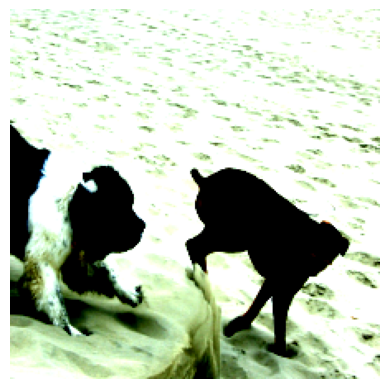

One dog is chasing another one on the beach .


In [24]:
# show an example image and caption
image, caption = train_dataset[122]
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')
plt.show()
print(caption)


In [25]:
# import zipfile
# import os

# # Define the path to the folder you want to zip
# folder_path = '/content/models/Q4'

# # Define the path for the zip file
# zip_path = '/content/models/Q4.zip'

# # Create a zip file of the folder
# with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
#     for root, dirs, files in os.walk(folder_path):
#         for file in files:
#             zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), folder_path))

# # Download the zip file
# from google.colab import files
# files.download(zip_path)


In [32]:
# Initialize the encoder and decoder
encoder = Encoder(num_clusters=num_clusters, dim=dim)
decoder = Decoder(input_size, hidden_size, vocab_size)
model = ImageCaptioningModel(encoder, decoder)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"])

# Train the model
trainer = Trainer(model, optimizer, criterion, device, vocab, render=True)
trainer.train(train_loader, 201)
# change vocab (alpha, len > 2 ..)

# # Evaluate the model
# evaluator = Evaluator(model, device, vocab)
# scores = evaluator.evaluate(test_loader)
# print(scores)



Epoch 201/201:   1%|          | 4/625 [00:02<05:40,  1.82batch/s, BLEU1=0.286, BLEU2=0.121, BLEU3=0.0774, BLEU4=0.0522, loss=0.76]

Pred: a man and a woman walk behind him . `` but a black dog . a pond . deck .
Actu: two women jogging down a sidewalk in front of a person leaning on a bench in front of a lake . with another person

Pred: two young girls pose smiling for a picture with a christmas tree behind them . `` the rescue . ``
Actu: two girls stand in front of a christmas tree , with their arms around each other .

Pred: girl wearing a green jacket and hat stands on the grass among the many unoccupied red seats . playground .
Actu: a young girl in a parka playing a flute while walking by a fenced in field .

Pred: a skiny dog jumping in the air . a huge wooden ramp . it past a roller coaster . has
Actu: a brown and white dog is catching a tennis ball while standing on its hind legs .

Pred: a number eight racing dog is beating a number four racing dog slightly in a race . boat past the
Actu: a number eight racing dog is beating a number four racing dog slightly in a race .

Pred: a person uses a long-handled 

KeyboardInterrupt: 

In [37]:
# Customize matplotlib parameters
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['font.family'] = 'serif'
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['axes.linewidth'] = 3


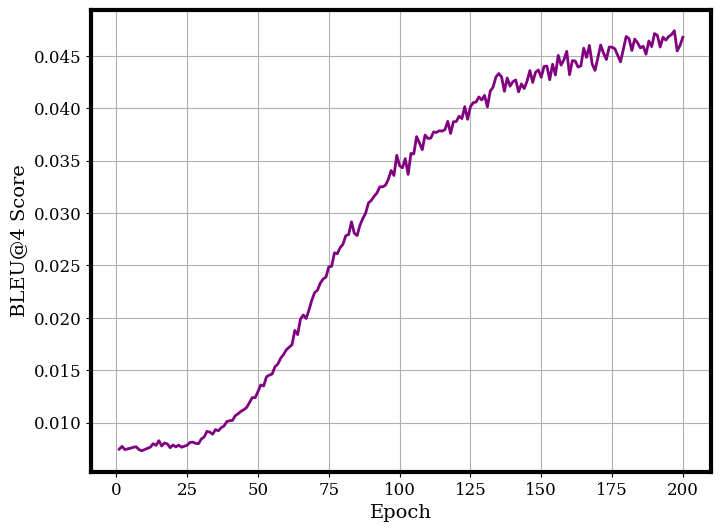

In [42]:
# Plot the training loss and BLEU scores
loss = trainer.loss
bleus = trainer.bleus
epochs = range(1, len(loss) + 1)

# plt.figure()
# plt.plot(epochs, loss)
# # plt.title('Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.grid()
# plt.savefig('plots/training_loss.pdf')
# plt.show()

plt.figure()
bleus = np.array(bleus)
# plt.plot(epochs, bleus[:, 0], label='BLEU-1')
# plt.plot(epochs, bleus[:, 1], label='BLEU-2')
# plt.plot(epochs, bleus[:, 2], label='BLEU-3')
# plt.plot(epochs, bleus[:, 3], label='BLEU-4')
# plt.plot(epochs, bleus[:, 0], label='BLEU-1', color='blue')
# plt.plot(epochs, bleus[:, 1], label='BLEU-2', color='green')
# plt.plot(epochs, bleus[:, 2], label='BLEU-3', color='red')
plt.plot(epochs, bleus[:, 3], label='BLEU-4', color='purple')
# plt.title('BLEU Scores')
plt.xlabel('Epoch')
plt.ylabel('BLEU@4 Score')
# plt.legend()
plt.grid()
plt.savefig('plots/bleu4.pdf')
plt.show()

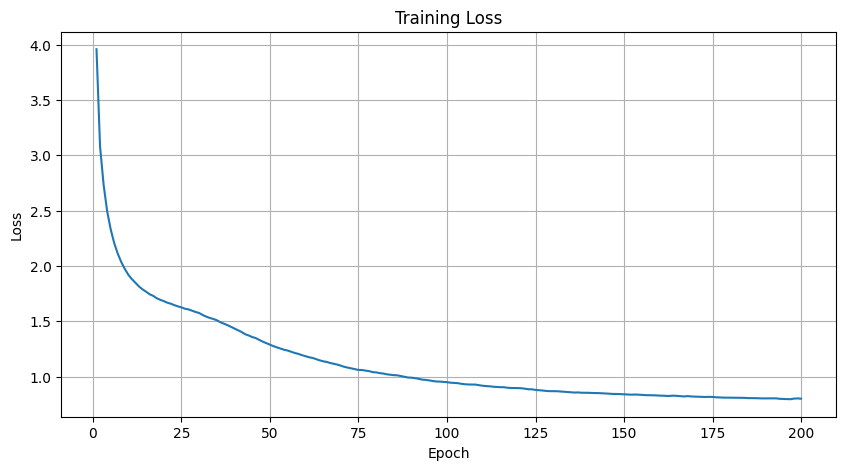

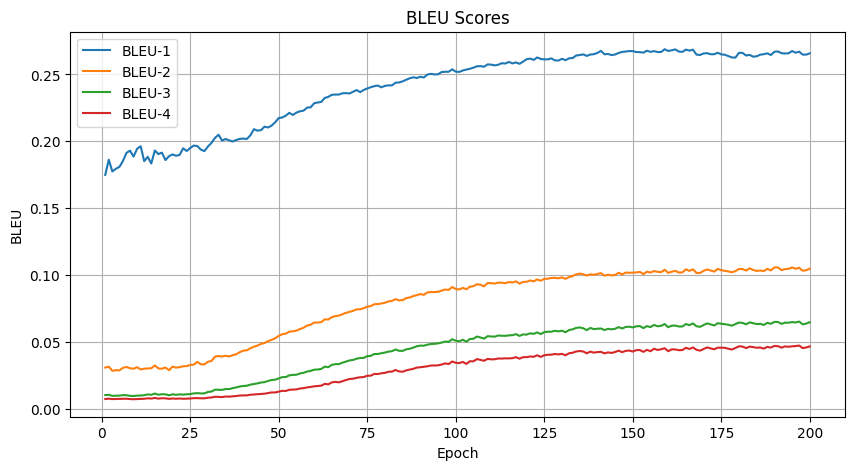

In [27]:
# Plot the training loss and BLEU scores
loss = trainer.loss
bleus = trainer.bleus
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
bleus = np.array(bleus)
plt.plot(epochs, bleus[:, 0], label='BLEU-1')
plt.plot(epochs, bleus[:, 1], label='BLEU-2')
plt.plot(epochs, bleus[:, 2], label='BLEU-3')
plt.plot(epochs, bleus[:, 3], label='BLEU-4')
plt.title('BLEU Scores')
plt.xlabel('Epoch')
plt.ylabel('BLEU')
plt.legend()
plt.grid()
plt.show()

Pred: a man and 4 dogs playing on the beach . `` . `` another mountain . `` . `` of
Actu: a dog running on the sand by the beach while his owner looks at the other dogs on the beach .



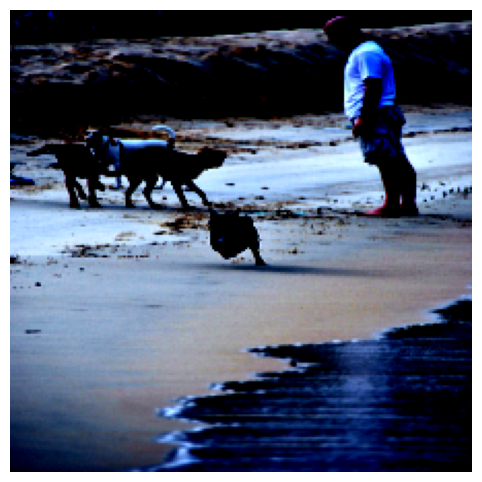

In [86]:
for images, captions in train_loader:
    captions = [vocab.tokenize(cap) for cap in captions]
    captions = [vocab.numericalize(cap) for cap in captions]
    lengths = [len(cap) for cap in captions]
    lengths, sort_idx = torch.tensor(lengths).sort(0, descending=True)
    captions = [captions[i] for i in sort_idx]
    images = images[sort_idx]
    captions = pad_sequence([torch.tensor(cap) for cap in captions], batch_first=True, padding_value=vocab.stoi["<PAD>"])
    images, captions = images.to(device), captions.to(device)

    predicted_ids = model.sample(images)
    batch_size = images.size(0)

    for i in range(batch_size):
        # References
        img_captions = captions[i].tolist()
        img_captions = [w for w in img_captions if w not in {vocab.stoi['<SOS>'], vocab.stoi['<EOS>'], vocab.stoi['<PAD>'], vocab.stoi['<UNK>']}]
        actual_words = [vocab.itos[idx] for idx in img_captions if idx in vocab.itos]

        # Hypotheses
        hypothesis_indices = predicted_ids[i].tolist()
        hypothesis_indices = [idx for idx in hypothesis_indices if idx != vocab.stoi['<UNK>']]
        predicted_words = [vocab.itos[idx] for idx in hypothesis_indices if idx in vocab.itos]

        # Print Predicted and Actual captions
        print(f"Pred: {' '.join(predicted_words)}")
        print(f"Actu: {' '.join(actual_words)}\n")

        # Show the image
        plt.imshow(images[i].permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()

        break
    break

Predicted: a man in a flowered bathing suit waterskies on one ski while being pulled by a rope . another person
Actual   : two dogs running in grassy area


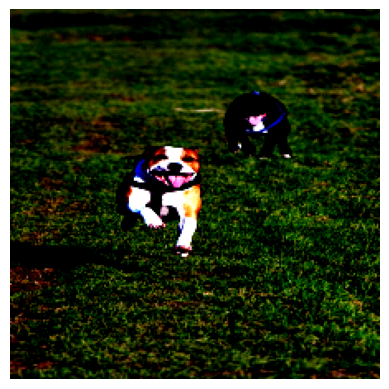

12604


In [94]:
id = np.random.randint(len(train_dataset))
image, caption = train_dataset[id]
image = image.unsqueeze(0).to(device)
predicted_ids = model.sample(image)
predicted_words = [vocab.itos[idx] for idx in predicted_ids.squeeze(0).tolist() if idx in vocab.itos]
print(f"Predicted: {' '.join(predicted_words)}")
print(f"Actual   : {caption}")
# show the image
plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()
print(id)


In [87]:
# Evaluate the model
evaluator = Evaluator(model, device, vocab)
scores = evaluator.evaluate(test_loader)
print(scores)

Evaluating: 100%|██████████| 640/640 [02:45<00:00,  3.88batch/s]

BLEU-1: 0.1932, BLEU-2: 0.0340, BLEU-3: 0.0131, BLEU-4: 0.0082
(0.1931938367904745, 0.034049691984846794, 0.013102668040160564, 0.00820869985500179)


In [1]:
# Task 5:
#  Machine translation with encoder and decoder, each built using a single hidden 
# layer LSTM network.
# GloVe representation is to be used as the word representation for English.
# IndicBERT representation to be used as the word representation for Indian languages.
# Performance of the image captioning system and the machine translation system is to 
# be given as BLEU@k scores with k = 1, 2, 3 and 4

# code for machine translation

# Define the GloVe vocabulary and the IndicBERT vocabulary
glove = torchtext.vocab.GloVe(name='6B', dim=300, cache='./kaggle/input/dataset/.vector_cache')
indicbert = torchtext.vocab.FastText(language='hi', cache='./kaggle/input/dataset/.vector_cache')

# Define the Encoder
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.embedding = nn.Embedding.from_pretrained(glove.vectors, freeze=True)
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False)

    def forward(self, x):
        # Embed the input word indices
        embeddings = self.embedding(x)
        # Pass the embeddings through the RNN
        outputs, (hidden, cell) = self.rnn(embeddings)
        return outputs, hidden, cell
    
    def initHidden(self, batch_size, device):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))
    
# Define the Decoder
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding.from_pretrained(indicbert.vectors, freeze=True)
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        # Embed the input word indices
        embeddings = self.embedding(x)
        # Pass the embeddings through the RNN
        outputs, (hidden, cell) = self.rnn(embeddings, (hidden, cell))
        # Linear layer to predict word probabilities
        outputs = self.out(outputs)
        return outputs, hidden, cell
    
    def initHidden(self, batch_size, device):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))
    
# Define the Machine Translation Model
class MachineTranslationModel(nn.Module):
    def __init__(self, encoder, decoder):
        super(MachineTranslationModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target):
        # Pass the source sentence through the encoder
        encoder_outputs, hidden, cell = self.encoder(source)
        # Initialize the decoder hidden state with the encoder hidden state
        decoder_hidden = hidden
        decoder_cell = cell
        # Initialize the input to the decoder with the <SOS> token
        input = target[:, 0].unsqueeze(1)
        outputs = []
        for t in range(1, target.size(1)):
            # Pass the input, hidden state, and cell state to the decoder
            output, decoder_hidden, decoder_cell = self.decoder(input, decoder_hidden, decoder_cell)
            outputs.append(output)
            # Get the predicted word indices for the next time step
            predicted = output.argmax(2)
            # Update the input to the decoder for the next time step
            input = predicted
        return torch.stack(outputs, 1)
    
    def sample(self, source, max_seq_length=20):
        # Pass the source sentence through the encoder
        encoder_outputs, hidden, cell = self.encoder(source)
        # Initialize the decoder hidden state with the encoder hidden state
        decoder_hidden = hidden
        decoder_cell = cell
        # Initialize the input to the decoder with the <SOS> token
        input = torch.tensor([vocab.stoi["<SOS>"]]).unsqueeze(0).to(device)
        outputs = []
        for t in range(max_seq_length):
            # Pass the input, hidden state, and cell state to the decoder
            output, decoder_hidden, decoder_cell = self.decoder(input, decoder_hidden, decoder_cell)
            outputs.append(output)
            # Get the predicted word indices for the next time step
            predicted = output.argmax(2)
            # Update the input to the decoder for the next time step
            input = predicted
        return torch.stack(outputs, 1)
    
# Define the hyperparameters
input_size = glove_dim
hidden_size = 512
output_size = len(indicbert.stoi)
num_layers = 1
bidirectional = False
num_epochs = 51
batch_size = 32
learning_rate = 0.001

# Initialize the encoder and decoder
encoder = Encoder(input_size, hidden_size, num_layers, bidirectional)
decoder = Decoder(input_size, hidden_size, output_size, num_layers, bidirectional)
model = MachineTranslationModel(encoder, decoder)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=indicbert.stoi["<PAD>"])

# Train the model
trainer = Trainer(model, optimizer, criterion, device, indicbert, render=True)
trainer.train(train_loader, num_epochs)

# Evaluate the model
evaluator = Evaluator(model, device, indicbert)
scores = evaluator.evaluate(test_loader)
print(scores)
